In [4]:
import os
import os.path as path
import re
from enum import Enum

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import matplotlib.patheffects as PathEffects
import pandas as pd
import seaborn as sns

import tafra
import ptitprince as pt

mpl.style.use('seaborn')
# %matplotlib notebook
# xkcd-colors: https://matplotlib.org/stable/_images/sphx_glr_colors_003.png

## Hallway Parameters and Definitions

In [6]:
class Boxes(Enum):
    SmallL = 10
    SmallC = 11
    SmallR = 12
    LargLC = 20
    LargCR = 21
    LargLR = 22
    
# w x d x h
smBox = [.6, .3, .9]
lgBox = [.95, .3, 1.8]
pRadius = .225
hwWidth = 2.85
segmentLength = 2
hwStartX = [0, 4, 8]

hallway1 = [
            Boxes.SmallC,
            Boxes.SmallC,
            Boxes.LargCR,
            Boxes.SmallL,
            Boxes.SmallR,
            Boxes.SmallC,
            Boxes.LargLR,
            Boxes.SmallL,
            Boxes.SmallL,
            Boxes.LargLC, # transition to 5
            Boxes.SmallC,
            Boxes.SmallR,
            Boxes.LargLR,
            Boxes.SmallC,
            Boxes.SmallL,
            Boxes.SmallR,
            Boxes.LargCR,
            Boxes.SmallC,
            Boxes.SmallC
]

hallway2 = [
            Boxes.SmallL,
            Boxes.SmallC,
            Boxes.LargCR,
            Boxes.SmallL,
            Boxes.SmallL,
            Boxes.SmallR,
            Boxes.LargLC,
            Boxes.SmallR,
            Boxes.SmallL,
            Boxes.LargCR, # transition to 3
            Boxes.SmallR,
            Boxes.SmallL,
            Boxes.LargLR,
            Boxes.SmallC,
            Boxes.SmallL,
            Boxes.SmallC,
            Boxes.LargCR,
            Boxes.SmallC,
            Boxes.SmallL
]

hallway3 = [
            Boxes.SmallL,
            Boxes.SmallC,
            Boxes.LargCR,
            Boxes.SmallR,
            Boxes.SmallL,
            Boxes.SmallC,
            Boxes.LargLR,
            Boxes.SmallL,
            Boxes.SmallC,
            Boxes.LargLC, # transition to 7
            Boxes.SmallR,
            Boxes.SmallR,
            Boxes.LargLC,
            Boxes.SmallC,
            Boxes.SmallR,
            Boxes.SmallL,
            Boxes.LargCR,
            Boxes.SmallC,
            Boxes.SmallL
]

hallways = [hallway1, hallway2, hallway3]

## Map Drawing Functions

In [7]:
def map_hallways():
    length = (4 + len(hallway1)) * segmentLength
    fig, axs = plt.subplots(3,1,figsize=(length, hwWidth*3.3))
    for idx,(ax, hallway) in enumerate(zip(axs, (hallway1, hallway2, hallway3))):
        create_map(hallway, ax)
        ax.text(-segmentLength, hwWidth/2, 
                f"HW-{idx+1}", fontsize=56, 
                va='center', ha='left')
        
    return fig, axs

def create_map(hallway, ax):
    # total length is 3 empty rooms + no. of obstacles
    length = (3 + len(hallway)) * segmentLength
    
    ax.set_axis_off()
    ax.set_xlim((0, length))
    ax.set_ylim((0, hwWidth))
    # background
    rect = Rectangle((0, 0), length, hwWidth, 
                     edgecolor='none', facecolor='xkcd:ivory', zorder=0)
    # Add the patch to the Axes
    ax.add_patch(rect)
    
    # the hallway obstacles
    # since first 2 rooms are empty, the actual first room starts at segmentLength*2
    # obstacles are placed at the end of a segment so the box starts at
    # segmentLength - boxDepth in relation to the room start
    boxPatches = []
    roomEnd = 3 * segmentLength
    for box in hallway:
        if box == Boxes.SmallL:
            dY,dX,_ = smBox
            anchor = (roomEnd - dX, hwWidth-dY)
        elif box == Boxes.SmallC:
            dY,dX,_ = smBox
            anchor = (roomEnd - dX, (hwWidth-dY) / 2)
        elif box == Boxes.SmallR:
            dY,dX,_ = smBox
            anchor = (roomEnd - dX, 0)
        elif box == Boxes.LargLC:
            dY,dX,_ = lgBox
            dY *= 2 # *2 because it's 2 boxes next to each other
            anchor = (roomEnd - dX, hwWidth-dY) 
        elif box == Boxes.LargCR:
            dY,dX,_ = lgBox
            dY *= 2 # *2 because it's 2 boxes next to each other
            anchor = (roomEnd - dX, 0)
        elif box == Boxes.LargLR:
            dY,dX,_ = lgBox
            anchor = (roomEnd - dX, hwWidth - dY)
            boxPatches.append(box_patch(anchor, dX, dY))
            anchor = (roomEnd - dX, 0)
            boxPatches.append(box_patch(anchor, dX, dY))
            
            roomEnd += segmentLength
            continue
        
        boxPatches.append(box_patch(anchor, dX, dY))
        roomEnd += segmentLength
    
    pc = PatchCollection(boxPatches, edgecolor='none',
                 facecolor='xkcd:chocolate', zorder=10)
    ax.add_collection(pc)
    
    roomEnd = segmentLength
    dividers = []
    while roomEnd < length:
        dividers.append(Rectangle((roomEnd, 0), .1*segmentLength, hwWidth))
        roomEnd += segmentLength
    
    pc = PatchCollection(dividers, edgecolor='none', 
                         facecolor= 'xkcd:grey', alpha=.6, zorder=5)
    ax.add_collection(pc)
                        
def box_patch(anchor, dX, dY):
    return Rectangle(anchor, dX, dY)

In [8]:
subjPattern = re.compile(r"^\d+$")
trialPattern = re.compile(r"(?P<block>\d\d)_(?P<trial>\d\d)(?P<data>\w+)\.tsv")

ID01 = "00"
ID02 = "01"
ID03 = "02"
IDENTS = [ID01, ID02, ID03]

In [9]:
subjects = [d for d in os.listdir() if subjPattern.match(d)]#[:-1]
subjects = sorted(subjects)

colors = mcolors.XKCD_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())
as_hex = [(mcolors.to_hex(c), n) for c,n in by_hsv]

step = (len(as_hex)-3) // len(subjects)
subj_colors = as_hex[3::step]

In [10]:
def load_subject(subjId):
    datadict = {
        ID01 : {ID01 : [], ID02 : [], ID03 : []}, # block 1
        ID02 : {ID01 : [], ID02 : [], ID03 : []}, # block 2
        ID03 : {ID01 : [], ID02 : [], ID03 : []} # block 3
    }
    files = os.listdir(subjId)
    for file in files:
        match = trialPattern.match(file)
        if not match:
            print("Error!", file)
            continue
        block_id = match.groups()[0]
        trial_id = match.groups()[1]
        datadict[block_id][trial_id].append(file)
        
    return datadict

In [11]:
def vec2coord(s:pd.Series, keep=[0,1,2]):
    """Convert the stored vector in str: '(x,y,z)' to df with columns x&y"""
    vecs = s.apply(lambda v: np.array(v[1:-1].split(', ')).astype(float))
    p = pd.DataFrame(np.stack(vecs.values))
    p = p[p.columns[keep]]
    labels = np.array(['x', 'y', 'z'])
    p.columns = labels[:len(keep)]
    p.index = s.index
    return p

def pos2path(s:pd.Series, hallwayId:int):
    # convert text vector to 2d vector array
    # [2,0] "rotates" vector, hallways are drawn left -> right
    # so x (left, right) becomes y, and z (forward) becomes x
    p = vec2coord(s, [2,0])
    # 0-center path by subtracting hallway offset (id * 4)
    # in Unity right is positive, left is negative
    # we must negate to get correct orientation
    # then add half-width to put correct starting position
    p.y = (p.y - hallwayId * 4) * -1 + hwWidth / 2
    # add segment-length to account for first empty room behind start
    p.x += segmentLength
    return p

def round_to_multiple(number, multiple):
    return multiple * round(number / multiple)

def draw_path(s:pd.Series, axs, hwId, color):
    # startoffset is rounded down start position
    # offset is 0, 4 or 8
    # center start in hallway
    p = pos2path(s, hwId)
    return axs[hwId].plot(p.x, p.y, 'o-', 
            lw=.45, alpha=.2, color=color)

def draw_all_paths(subjId:str, colors = ['xkcd:maroon', 'xkcd:lightblue', 'xkcd:green']):
    datadict = load_subject(subjId)
    fig, axs = map_hallways()
    fig.suptitle(subjId, fontsize=32)

    for idx, blockId in enumerate(IDENTS):
        for trialId in IDENTS:
            trial = datadict[blockId][trialId]

            # -1 --> trial config
            filepath = path.join(subjId, trial[-1])
            df = pd.read_csv(filepath, sep='\t')
            hwId = int(df.Hallway[0][-1]) - 1

            # 0 --> engine data
            filepath = path.join(subjId, trial[0])
            df = pd.read_csv(filepath, sep='\t')
            s = df.XRHeadPos

            draw_path(s, axs, hwId, colors[idx])

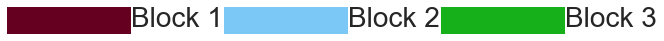

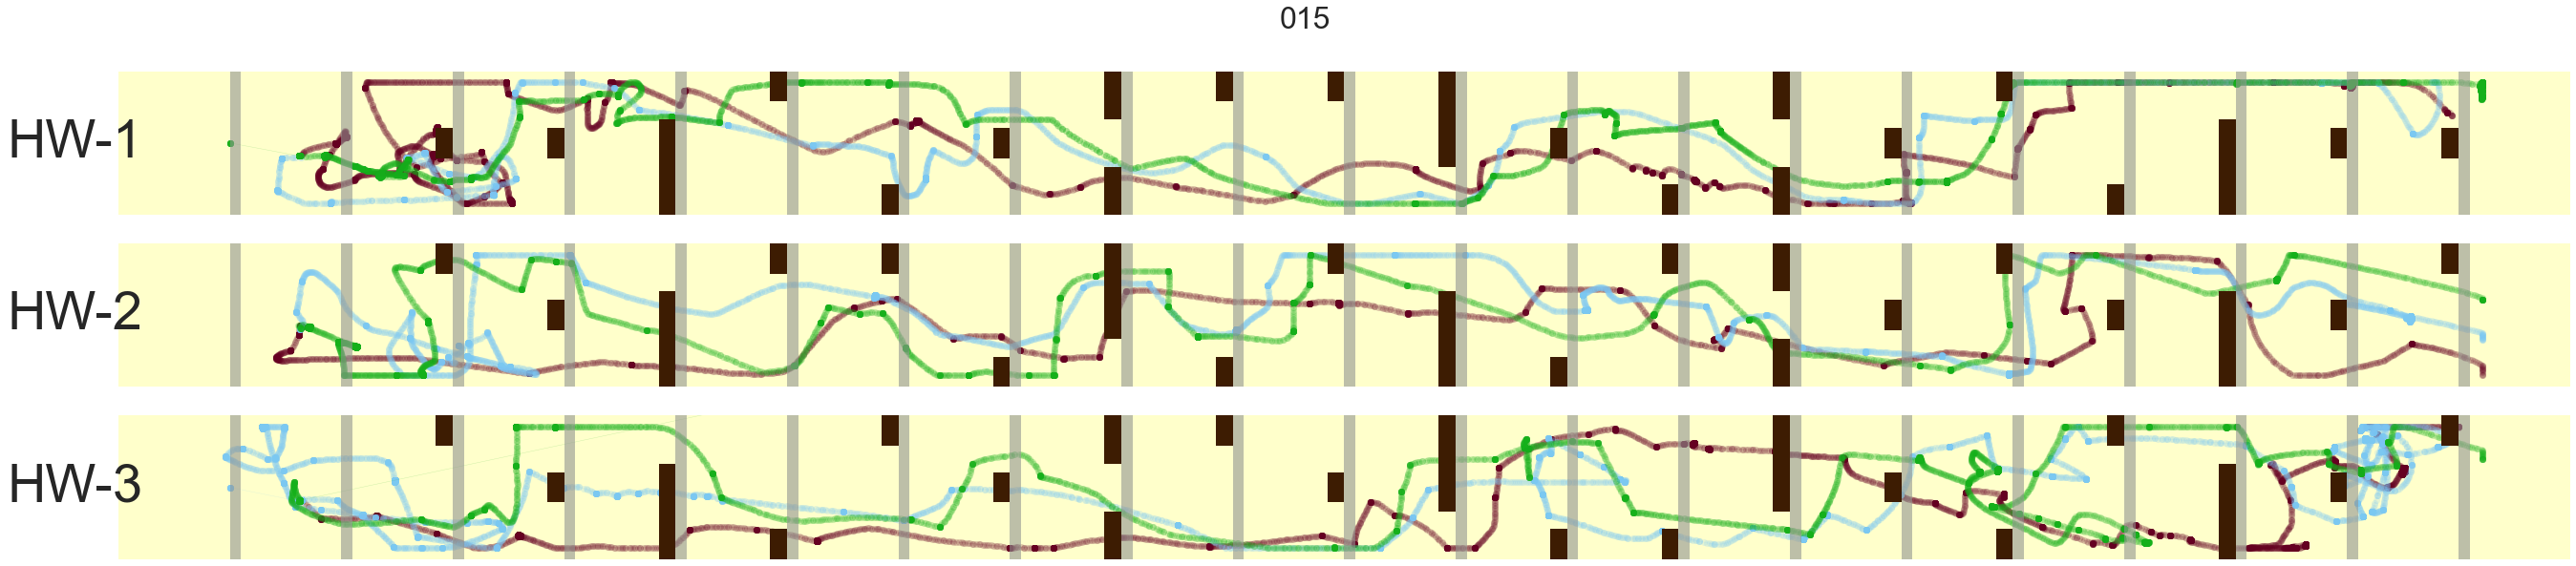

In [12]:
fig, ax = plt.subplots(figsize=(10,.5))
ax.set_axis_off()
ax.add_patch(Rectangle((0,.33), 2, .33, edgecolor='none', facecolor='xkcd:maroon'))
ax.text(2,.5,'Block 1',va='center', ha='left', fontsize=28)
ax.add_patch(Rectangle((3.5,.33), 2, .33, edgecolor='none', facecolor='xkcd:lightblue'))
ax.text(5.5,.5,'Block 2',va='center', ha='left', fontsize=28)
ax.add_patch(Rectangle((7,.33), 2, .33, edgecolor='none', facecolor='xkcd:green'))
ax.text(9,.5,'Block 3',va='center', ha='left', fontsize=28)
ax.set_xlim((0,9))
ax.set_ylim((0.33,.66))
                       

# draw_all_paths('001')
# draw_all_paths('004')
draw_all_paths('015')

In [9]:
def plot_eye_movement():
    fig, axs = plt.subplots(3,3, figsize=(24,12), dpi=100)
    fig.suptitle("Eye Movement")

    axs[0,0].set_title('Gaze Ignored', fontsize=12)
    axs[0,1].set_title('Gaze Locked', fontsize=12)
    axs[0,2].set_title('Gaze Assisted', fontsize=12)
    axs[0,0].text(-.2, .5, 'Block-1', rotation=90, va='center', ha='right', fontsize=12)
    axs[1,0].text(-.2, .5, 'Block-2', rotation=90, va='center', ha='right', fontsize=12)
    axs[2,0].text(-.2, .5, 'Block-3', rotation=90, va='center', ha='right', fontsize=12)

    for idx in range(len(subjects)):
        subjId = subjects[idx]
        datadict = load_subject(subjId)
        c = subj_colors[idx][1]
        for blockId, block in enumerate(datadict.values()):
            for trialId, trialData in enumerate(block.values()):
                try:
                    fConfig = trialData[-1]
                    fEyeL = trialData[3]
                    fEyeR = trialData[4]
                    dfCfg = pd.read_csv(path.join(subjId, fConfig), sep='\t')
                    dfL = pd.read_csv(path.join(subjId, fEyeL), sep='\t')
                    dfR = pd.read_csv(path.join(subjId, fEyeR), sep='\t')
                except (pd.errors.EmptyDataError, FileNotFoundError) as e:
                    print(f"Could not load subject: {subjId}")
                    print(e)
                except IndexError as e:
                    print(f"IndexError! For trial {trialId} \w data {trialData} in block {blockId}")
                    print(e)


                condition = dfCfg.GazeCondition[0]

                eyePosL = vec2coord(dfL.PosInSensor, [0,1])
                eyePosL = eyePosL[(eyePosL.x <= 1) & (eyePosL.x >= 0)]
                eyePosL = eyePosL[(eyePosL.y <= 1) & (eyePosL.y >= 0)]
                eyePosR = vec2coord(dfR.PosInSensor, [0,1])
                eyePosR = eyePosR[(eyePosR.x <= 1) & (eyePosR.x >= 0)]
                eyePosR = eyePosR[(eyePosR.y <= 1) & (eyePosR.y >= 0)]

                if 'ignored' in condition.lower():
                    col = 0
                elif 'fixed' in condition.lower():
                    col = 1
                elif 'assist' in condition.lower():
                    col = 2

                axs[blockId,col].plot(eyePosL.x, eyePosL.y, 'o--',
                                      lw=.3, markersize=2, 
                                      color=c, alpha=.1)
                axs[blockId,col].plot(eyePosR.x+1.1, eyePosR.y, 'o--',
                                      lw=.3, markersize=2,
                                      color=c, alpha=.1)

                if idx == 0:
                    axs[blockId,col].text(0.9, .9, 'L', va='bottom', ha='center', fontsize=10)
                    axs[blockId,col].text(2, .9, 'R', va='bottom', ha='center', fontsize=10)
                    axs[blockId,col].set_xlim((0,2.1))
                    axs[blockId,col].set_ylim((0,1))
                    axs[blockId,col].set_xticks([0, .5, 1, 1.1, 1.5, 2.1], [0, .5, 1, 0, .5, 1])
                    bbox = Rectangle((0,0),1,1,edgecolor='gray', facecolor='none', lw=.25)
                    axs[blockId,col].add_patch(bbox)
                    bbox = Rectangle((1.1,0),1,1,edgecolor='gray', facecolor='none', lw=.25)
                    axs[blockId,col].add_patch(bbox)
                    
def plot_subject_colors(n_columns=10):
    rows = len(subjects) // n_columns + 1
    fig, axs = plt.subplots(rows, n_columns, figsize=(n_columns,rows), dpi=80)
    plt.tight_layout()
    
    if len(axs.shape) < 2:
        axs = axs[None,:]
    rows, cols = axs.shape
    
    for row in range(rows):
        for col in range(cols):
            idx = row * n_columns + col
            
            ax = axs[row, col]
            ax.set_axis_off()
            ax.set_aspect('equal')
            ax.set_xlim((0,1))
            ax.set_ylim((0,1))
            
            if idx >= len(subjects): continue
            
            subjId = subjects[idx]
            c, cname = subj_colors[idx]
            
            ax.add_patch(Rectangle((0,0), 1, 1, edgecolor='none', facecolor=cname))
            # ax.add_patch(Rectangle((0.2,.33),.6,.33, edgecolor='none', facecolor='white'))
            
            txt = ax.text(0.5, 0.5, subjId, fontsize=12, va='center', ha='center', alpha=1)
            txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
            
    plt.show()

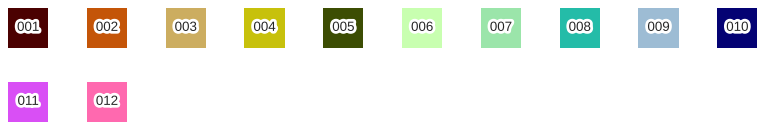

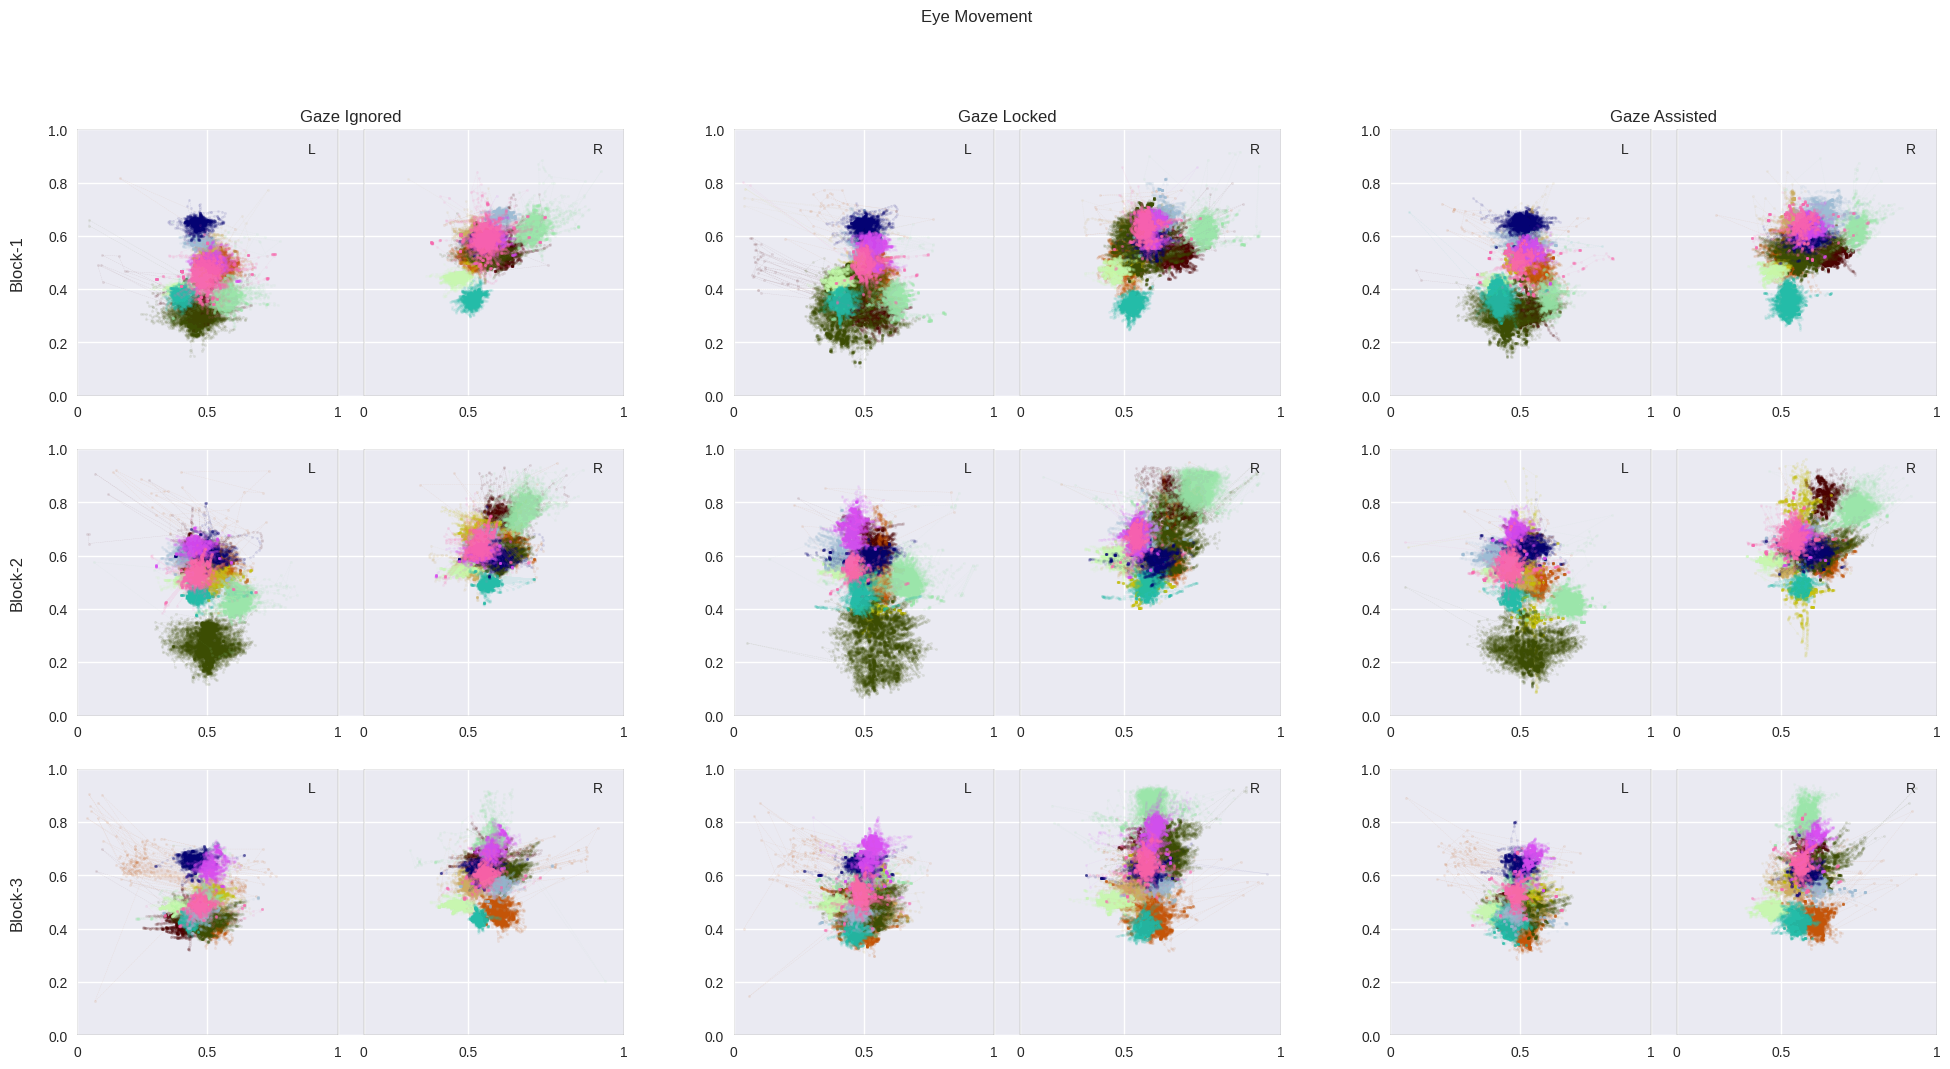

In [10]:
allSubj = subjects
# subjects = ['001', '004', '005']
plot_subject_colors()
plot_eye_movement()
subjects = allSubj

In [11]:
def get_filtered_eye_position(s:pd.Series):
    eyePos = vec2coord(s, [0,1])
    eyePos = eyePos[(eyePos.x <= 1) & (eyePos.x >= 0)]
    eyePos = eyePos[(eyePos.y <= 1) & (eyePos.y >= 0)]
    return eyePos

def get_eye_distance_travelled(s:pd.Series):
    eyePos = get_filtered_eye_position(s)
    delta = eyePos.diff()
    return np.sqrt(delta.x ** 2 + delta.y ** 2).sum()
    
def get_eye_average_dist(s_left:pd.Series, s_right:pd.Series):
    distL = get_eye_distance_travelled(s_left)
    distR = get_eye_distance_travelled(s_right)
    return (distL + distR) / 2

In [12]:
data = np.zeros((3, 3, len(subjects)))

for idx, subjId in enumerate(subjects):
    datadict = load_subject(subjId)
    for blockIdx, blockId in enumerate(IDENTS):
        block = datadict[blockId]
        for trialId in IDENTS:
            trialData = block[trialId]
            fConfig = trialData[-1]
            fEyeL = trialData[3]
            fEyeR = trialData[4]
            dfCfg = pd.read_csv(path.join(subjId, fConfig), sep='\t')
            dfL = pd.read_csv(path.join(subjId, fEyeL), sep='\t')
            dfR = pd.read_csv(path.join(subjId, fEyeR), sep='\t')
            
            condition = dfCfg.GazeCondition[0].lower()
            conIdx = 0 if 'ignored' in condition else 1 if 'fixed' in condition else 2
            
            data[blockIdx, conIdx, idx] = get_eye_average_dist(dfL.PosInSensor, dfR.PosInSensor)

<AxesSubplot:xlabel='Block', ylabel='Distance'>

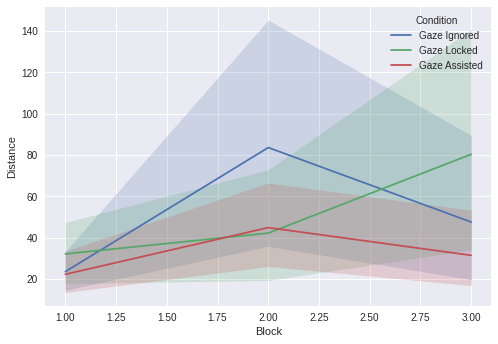

In [13]:
iterables = [[1,2,3],['Gaze Ignored', 'Gaze Locked', 'Gaze Assisted'], subjects]
index = pd.MultiIndex.from_product(iterables, names=['Block', "Condition", "Subject-ID"])
dat = pd.DataFrame(data=data.reshape(-1, 1), index=index, columns = ['Distance' ])

sns.lineplot(data=dat, x='Block', y='Distance', hue='Condition')

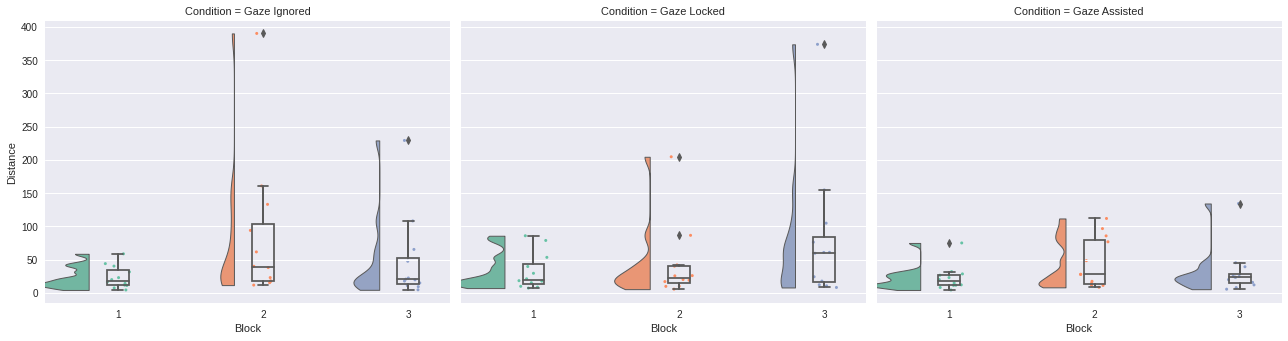

In [14]:
# pt.RainCloud(data=dat.reset_index(), x='Block', y='Distance', hue='Condition', orient='h')
# Rainclouds with FacetGrid
d = dat.reset_index()
g = sns.FacetGrid(d, col = "Condition", height = 6)
g = g.map_dataframe(pt.RainCloud, x = "Block", y = "Distance", data = d, orient = "v")

g.fig.subplots_adjust(top=0.75)
# g.fig.suptitle("Figure P13\n Using FacetGrid for More Complex Designs",  fontsize=26)

In [15]:
def prepare_single_eye(df:pd.DataFrame, is_combined=False) -> (str, pd.DataFrame):
    tmp = df.drop(columns=[c for c in df.columns if "Unnamed" in c])\
        .set_index(['TrackerTimeStamp', 'TimeStamp'])
    sensor_pos = vec2coord(tmp.PosInSensor, [0,1])
    gaze_pos = vec2coord(tmp.GazeOriginInEye, [0,1,2])
    gaze_dir = vec2coord(tmp.GazeDirectionNormInEye, [0,1,2])
    idx = tmp.EyeIndex.iloc[0]
    tmp = tmp.drop(columns=["PosInSensor", "GazeOriginInEye", "GazeDirectionNormInEye", 'EyeIndex'])
    eye = pd.concat((tmp, sensor_pos, gaze_pos, gaze_dir), axis=1, keys=["Other", "SensorPos", "GazeOrigin", "GazeDirection"])
    if is_combined:
        eye = eye.drop(columns=[('Other', 'Openness'), ('Other', 'PupilDiameter')]).drop(columns=["SensorPos"])
    return idx, eye

def merge_all_blocks_eyedata(subjId):
    block_eyes = []
    for block in IDENTS:
        trial_eyes = []
        for trial in IDENTS:
            fileL = f"{block}_{trial}SingleEyeDataRecordL.tsv"
            fileR = f"{block}_{trial}SingleEyeDataRecordR.tsv"
            fileC = f"{block}_{trial}SingleEyeDataRecordC.tsv"
            df = pd.read_csv(path.join(subjId, fileL), sep='\t')
            idxL, eyeL = prepare_single_eye(df)
            df = pd.read_csv(path.join(subjId, fileR), sep='\t')
            idxR, eyeR = prepare_single_eye(df)
            df = pd.read_csv(path.join(subjId, fileC), sep='\t')
            idxC, eyeC = prepare_single_eye(df, True)

            all_eyes = pd.concat([eyeL, eyeR, eyeC], axis=1, keys=[idxL, idxR, idxC])
            trial_eyes.append(all_eyes)

        block_eyes.append(pd.concat(trial_eyes, axis=0, keys=IDENTS))

    blockDf = pd.concat(block_eyes, axis=0, keys=IDENTS)
    names = list(blockDf.index.names)
    names[:2] = ['Block', 'Trial']
    blockDf.index.names = names
    
    return blockDf

In [22]:
try:
    completeEyeData = pd.read_hdf('data.h5', key='complete_eye_data')
except (FileNotFoundError, KeyError) as e:
    print("Failed to load Eye Data from file data.h5; Recalculating")
    all_eye_data = []
    for subjId in subjects:
        all_eye_data.append(merge_all_blocks_eyedata(subjId))

    completeEyeData = pd.concat(all_eye_data, axis=1, keys=subjects)
    completeEyeData.to_hdf('data.h5', key='complete_eye_data', complevel=7)

Failed to load Eye Data from file data.h5; Recalculating


NameError: name 'df' is not defined